In [1]:
import os
import sys
import math
import random
from myutils import *

In [2]:
import numpy as np # todo: update numpy so we can use the new, proper random number Generator class
np.__version__

'2.1.3'

In [3]:
import pandas as pd
pd.__version__

'2.2.3'

In [4]:
import networkx as nx 
nx.__version__

'3.4.2'

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns

## Directory paths

In [6]:
# Define directories
projdir = os.path.abspath(os.getcwd())

### Import own methods

In [7]:
sys.path.insert(0, projdir)

In [8]:
import sys
import os
# Add the directories to the Python path
sys.path.append(os.path.abspath('/home/claudio/tesi/modular_model/transactions/methods'))
sys.path.append(os.path.abspath('/home/claudio/tesi/modular_model'))
import methods.model as model
import methods.dists as dists

In [ ]:
dists.powlaw_ppf(1.5,1,1000)(np.random.uniform(0,1,size=10000))

1.5066458188469407

### Demonstration run

In [12]:
# Short run with a few nodes
N = 100
X = 10
# initialize the model                        # Defaults:
nodes = model.create_nodes(N,spending=0.5)    # Homogeneous activity
acts = model.initialize_activations(nodes)    # Poissonian activation
atts = model.initialize_attractivities(nodes) # Random selection
bals = model.initialize_balances(nodes)       # 1.0000 initial balance
# print the output header
header = ["timestamp","source","target","amount","source_bal","target_bal"]
print(",".join(header))
# run the model
for i in range(X):
    transaction = model.transact(nodes,acts,atts,bals)
    print(",".join([str(transaction[term]) for term in header]))

timestamp,source,target,amount,source_bal,target_bal
0.0041934275489225225,41,74,0.4906,0.5094,1.4906
0.009563265215521794,77,40,0.4989,0.5011,1.4989
0.014960125668621153,58,27,0.4965,0.5035,1.4965
0.027070627141260965,66,69,0.5017,0.4983,1.5017
0.043159637743975035,58,30,0.2545,0.2490,1.2545
0.059623410535012064,1,21,0.5016,0.4984,1.5016
0.07022551949565026,78,55,0.5101,0.4899,1.5101
0.08910521071183682,41,44,0.2523,0.2571,1.2523
0.09599134940131639,50,56,0.5010,0.4990,1.5010
0.10142820159512932,47,25,0.5016,0.4984,1.5016


### Now with inputs

500_000 (tr) * x (days)

In [ ]:
# Example run
N = 5000
T = 5 # nr of days

# Create activity and attractivity distributions               # Options:
# unif_act, unif_att = dists.paired_samples(N)                   # Uncorrelated samples from the uniform distribution
#unif_act, unif_att = dists.paired_samples(N,same=True)         # Two of the same sample from the uniform distribution
unif_act, unif_att = dists.paired_samples(N,params={'copula':'joe','reversed':False,'theta':3.67})  # Coupled samples
vect_act = dists.scale_pareto(unif_act, beta=2.0)              # Pareto, normalized to a mean of 1
vect_att = dists.scale_pareto(unif_att, beta=1.5)              # Can be different

# Initialize the model                                                                     # Options:                     
# nodes = model.create_nodes(N, activity=vect_act, attractivity=vect_att, spending=0.2)      # Spending probability (or, heterogeneous with a list/array)
#nodes = model.create_nodes(N, activity=vect_act, attractivity=vect_att, burstiness=2)      # Shape param for Weibull inter-event times (or, a list/array)
nodes = model.create_nodes(N, activity=vect_act, attractivity=vect_att, mean_iet=24*60*60) # Mean activity once per 24 hours (in seconds)
# T = T*24*60*60                                                                            # Note: also adjust T accordingly
T=T*24
acts = model.initialize_activations(nodes)
atts = model.initialize_attractivities(nodes)
bals = model.initialize_balances(nodes,balances=100*np.ones(N),decimals=2) # 100.00 instead of 1.0000

# filename 
filename = os.path.join(projdir,"example.csv")
header = ["timestamp","source","target","amount","source_bal","target_bal"]

transactions = []
for i in range(T):
    transaction = model.transact(nodes, acts, atts, bals)
    transactions.append(transaction)
transactions_df = pd.DataFrame(transactions, columns=header)

df = transactions_df

df
# with open(filename, "w") as file:
#     file.write(",".join(header) + "\n")
#     t = 0
#     while t < T:
#         transaction = model.transact(nodes,acts,atts,bals)
#         file.write(",".join([str(transaction[term]) for term in header]) + "\n")
#         t = transaction["timestamp"]

,timestamp,source,target,amount,source_bal,target_bal
0,11.837435,1412,2515,50.52,49.48,150.52
1,29.576632,1791,3195,50.04,49.96,150.04
2,40.587910,1325,884,49.67,50.33,149.67
3,86.369628,1990,4130,48.23,51.77,148.23
4,87.719114,3153,2430,49.55,50.45,149.55
...,...,...,...,...,...,...
115,2033.026247,3114,126,49.41,50.59,149.41
116,2045.224723,3776,556,49.62,50.38,149.62
117,2047.556103,242,4907,49.88,50.12,149.88
118,2056.142470,2017,4281,48.76,51.24,148.76


### Transactions and balances

In [22]:
# Transaction data
dtypes = {}
dtypes['timestamp'] = 'float'
dtypes['source'] = 'int'
dtypes['target'] = 'int'
dtypes['amount'] = 'float'
dtypes['source_bal'] = 'float'
dtypes['target_bal'] = 'float'

In [23]:
# Load the data
filename = os.path.join(projdir,"example.csv")
txns = pd.read_csv(filename,dtype=dtypes)
# Drop the last transaction
txns.drop(txns[txns['timestamp']>=T].index,inplace=True) # drop the last transaction
# Print the number of transactions
print(f"example.csv: {len(txns)} transactions")

example.csv: 71 transactions


,timestamp,source,target,amount,source_bal,target_bal
0,1970-01-01 02:57:36.125562328,2,2,49.68,100.00,100.00
1,1970-01-01 03:58:14.523769209,4,4,50.35,100.00,100.00
2,1970-01-01 05:30:56.039854918,3,1,50.38,49.62,150.38
3,1970-01-01 13:01:53.593644524,3,4,25.17,24.45,125.17
4,1970-01-01 15:31:28.766756858,3,2,11.97,12.48,111.97
...,...,...,...,...,...,...
66,1970-01-14 11:04:40.016185365,0,1,11.35,11.00,48.72
67,1970-01-14 14:19:35.168902282,1,1,24.36,48.72,48.72
68,1970-01-14 14:28:12.880498842,4,1,15.00,15.29,63.72
69,1970-01-14 14:39:39.757048224,1,4,31.89,31.83,47.18


In [ ]:
# Get the total spent by each node
targets = txns.groupby("target").agg({'amount': ['count','sum','mean','median','max'],'source':'nunique'})
targets.columns = ["txns","total","mean","median","max","sources"]
targets.reset_index(inplace=True)


sources = txns.groupby("source").agg({'amount': ['count','sum','mean','median','max'],'target':'nunique'})
sources.columns = ["txns","total","mean","median","max","targets"]
sources.reset_index(inplace=True)

users = pd.merge(sources,targets,how='outer',left_on='source',right_on='target',suffixes=('_out','_in'))

users.rename(columns={'source':'address'},inplace=True)
users.drop(columns='target',inplace=True)
users

,address,txns_out,total_out,mean_out,median_out,max_out,targets,txns_in,total_in,mean_in,median_in,max_in,sources
0,0,18,1320.71,73.372778,52.655,209.28,17,22.0,1344.47,61.112273,44.465,258.42,21.0
1,1,12,302.61,25.217500,9.260,93.18,12,14.0,436.02,31.144286,27.175,82.24,14.0
2,2,14,479.23,34.230714,21.475,148.24,13,7.0,383.54,54.791429,17.470,192.15,7.0
3,3,18,429.55,23.863889,17.365,86.80,18,8.0,381.11,47.638750,26.440,170.78,8.0
4,4,28,1450.40,51.800000,36.870,251.27,26,27.0,1413.31,52.344815,32.510,392.91,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,65,6103.73,93.903538,76.030,338.07,50,103.0,6354.94,61.698447,46.380,286.90,91.0
996,996,49,3725.69,76.034490,61.710,239.35,44,52.0,3660.86,70.401154,42.175,317.35,50.0
997,997,10,703.72,70.372000,49.145,194.83,10,14.0,805.08,57.505714,40.765,206.52,14.0
998,998,18,1340.04,74.446667,58.400,283.56,15,21.0,1246.42,59.353333,40.640,333.61,21.0


<Axes: xlabel='txns_out', ylabel='txns_in'>

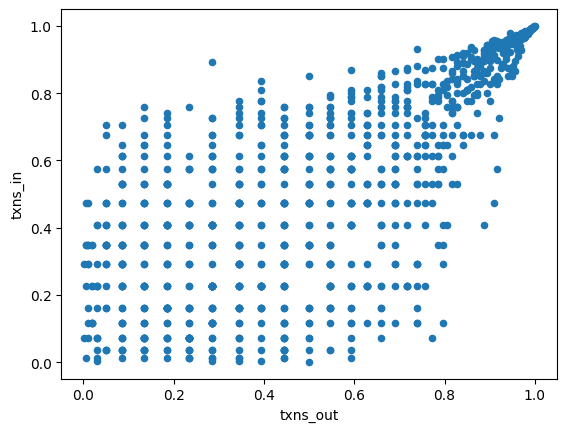

In [ ]:
users.rank(pct=True).plot(x='txns_out',y='txns_in',kind='scatter')

In [16]:
# Transform to get the daily transactions and day-end balances
txns['day'] = txns['timestamp'].apply(lambda x: math.ceil(x/(T/14))) # we're grabbing end-of-day balances

# Transform to account-based dataset
df_source = txns[['timestamp','day','source','source_bal']].rename(columns={'source': 'account', 'source_bal': 'balance'})
df_target = txns[['timestamp','day','target','target_bal']].rename(columns={'target': 'account', 'target_bal': 'balance'})
df_balance = pd.concat([df_source, df_target]).sort_values('timestamp')
# Aggregate daily (it is already sorted)
balances = df_balance.groupby(['account','day']).agg({'timestamp':'count',
                                                      'balance': 'last'}).rename(columns={'timestamp':'txns'}) # note the 'last' function from pandas
# Create a new multi-index with all account-days
all_observations = pd.MultiIndex.from_product([balances.index.levels[0], range(1,T//(24*60*60)+1)], names=['account', 'day'])
# Reindex your DataFrame to include all account-days and forward fill missing values
balances = balances.reindex(all_observations).fillna(method='ffill') # forward fill missing values to cover days with no transactions
# Get the timestamp, day, and account as columns
balances.reset_index(inplace=True)
balances['timestamp'] = balances['day']*24*60*60
# Print the number of observations
print(f"example.csv: {balances.shape[0]} day-account balance observations")
# Show the resulting dataframe
balances.head()

example.csv: 5 day-account balance observations


,account,day,txns,balance,timestamp
0,0,1,NaN,NaN,86400
1,1,1,NaN,NaN,86400
2,2,1,NaN,NaN,86400
3,3,1,NaN,NaN,86400
4,4,1,NaN,NaN,86400
